# imports

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from glob import glob
from os.path import basename, exists
from tiffile import imread
import laserbeamsize as lbs
import matplotlib as mpl
import re
import xarray as xr
import dask.array as da
import dask.dataframe as dd
import dask.array as da
from dask.distributed import Client, progress
import sys
import multiprocessing as mp
from scipy.ndimage import gaussian_filter
from lmfit.models import Gaussian2dModel
from lmfit import Model, Parameter
from lmfit.lineshapes import gaussian, lorentzian
mpl.rcParams['font.size'] = 20
import pandas as pd

# load data

In [2]:
file = '../data/200.0K_reduced.h5'
ds = xr.open_dataset(file)
ds

<xarray.Dataset>
Dimensions:      (time: 2048, row: 800, col: 800)
Coordinates:
  * time         (time) int32 0 1 2 3 4 5 6 ... 2042 2043 2044 2045 2046 2047
  * row          (row) int32 0 1 2 3 4 5 6 7 ... 792 793 794 795 796 797 798 799
  * col          (col) int32 0 1 2 3 4 5 6 7 ... 792 793 794 795 796 797 798 799
Data variables:
    image_stack  (time, row, col) float32 ...
Attributes:
    temperature:  200.0

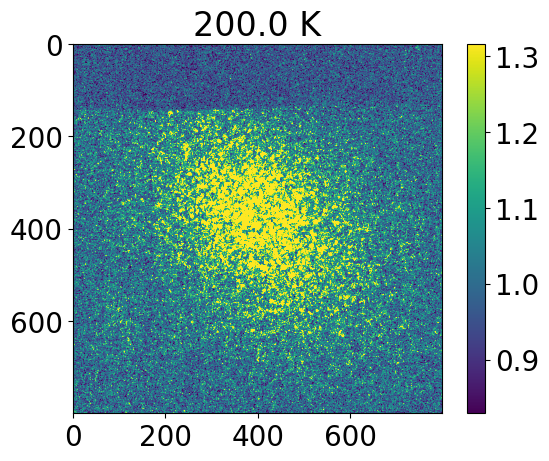

In [3]:
img = ds['image_stack'][1].compute().to_numpy()
plt.figure()
plt.title(f'{ds.attrs["temperature"]} K')
plt.imshow(img, vmin=np.percentile(img, 10), vmax=np.percentile(img, 90))
plt.colorbar()
plt.show()

# fit peak

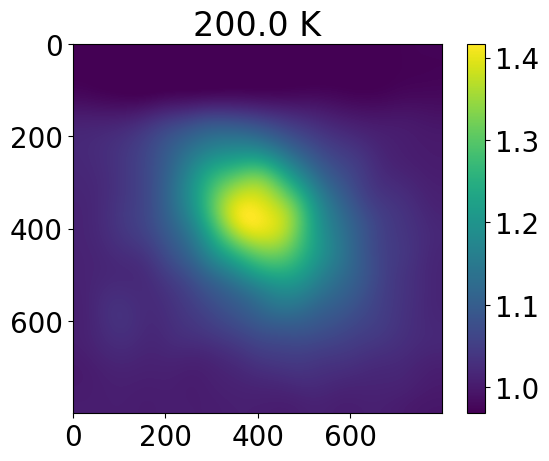

In [4]:
gimg = gaussian_filter(img, 35)

plt.figure()
plt.title(f'{ds.attrs["temperature"]} K')
plt.imshow(gimg, vmin=np.percentile(gimg, 10), vmax=np.percentile(gimg, 100))
plt.colorbar()
plt.show()

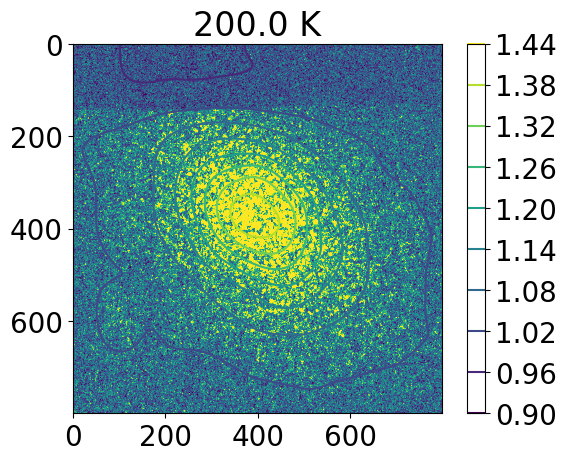

In [5]:
plt.figure()
plt.title(f'{ds.attrs["temperature"]} K')
plt.imshow(img, vmin=np.percentile(img, 10), vmax=np.percentile(img, 90))
plt.contour(gimg)
plt.colorbar()
plt.show()

In [6]:
# https://lmfit.github.io/lmfit-py/examples/example_two_dimensional_peak.html
def lorentzian2d(x, y, amplitude=1., centerx=0., centery=0., sigmax=1., sigmay=1.,
                 rotation=0, offset = 0):
    """Return a two dimensional lorentzian.

    The maximum of the peak occurs at ``centerx`` and ``centery``
    with widths ``sigmax`` and ``sigmay`` in the x and y directions
    respectively. The peak can be rotated by choosing the value of ``rotation``
    in radians.
    """
    xp = (x - centerx)*np.cos(rotation) - (y - centery)*np.sin(rotation)
    yp = (x - centerx)*np.sin(rotation) + (y - centery)*np.cos(rotation)
    R = (xp/sigmax)**2 + (yp/sigmay)**2

    return 2*amplitude*lorentzian(R)/(np.pi*sigmax*sigmay) + offset

x, y = np.indices(gimg.shape)
mod = Model(lorentzian2d, independent_vars=['x', 'y'])
params = mod.make_params(amplitude=1)
params['rotation'].set(value=1, min=0, max=np.pi/2)
params['sigmax'].set(value=50, min=0, max=500)
params['sigmay'].set(value=100, min=0, max=500)
params['centery'].set(value=384, min=200, max=500)
params['centerx'].set(value=374, min=200, max=500)
params['offset'].set(value=1)

error = 1 / np.sqrt(gimg).ravel()
result = mod.fit(img.ravel(), x=x.ravel(), y=y.ravel(), params=params, weights=1/error)

In [7]:
result

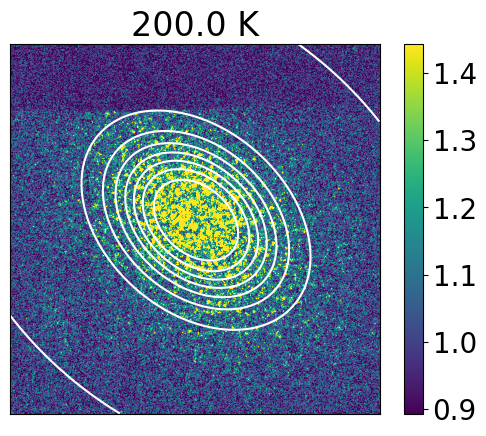

In [8]:
fit = mod.func(x, y, **result.best_values)

plt.figure()
plt.title(f'{ds.attrs["temperature"]} K')
plt.imshow(img, vmin=np.percentile(img, 20), vmax=np.percentile(img, 95))
plt.colorbar()
plt.contour(fit, colors=['w'])
plt.xticks([])
plt.yticks([])
plt.show()

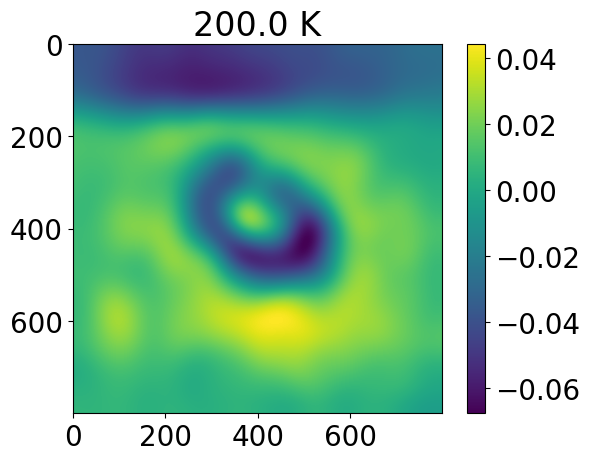

In [9]:
plt.figure()
plt.title(f'{ds.attrs["temperature"]} K')
plt.imshow(gimg-fit)#, vmin=np.percentile(img, 10), vmax=np.percentile(img, 90))
plt.colorbar()
plt.show()


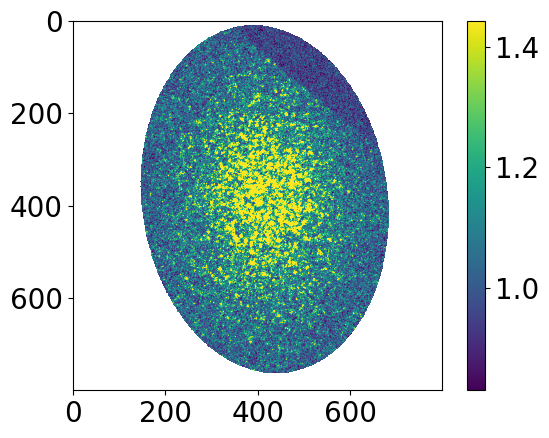

In [10]:
from scipy.ndimage import rotate

rimg = img.copy()
rimg[fit<np.percentile(fit, 50)] = -5
rimg = rotate(rimg, -np.rad2deg(result.best_values['rotation']), reshape=False, cval=np.nan)
rimg[rimg<0] = np.nan

plt.figure()
plt.imshow(rimg, vmin=np.percentile(img, 10), vmax=np.percentile(img, 95))
plt.colorbar()
plt.show()

C:\Users\rtumbleson\AppData\Local\Temp\ipykernel_1224\3511152131.py:2: RuntimeWarning: Mean of empty slice
  plt.plot(np.arange(len( np.nanmean(rimg, axis=0)[150:-150])) + 150, np.nanmean(rimg, axis=0)[150:-150])
C:\Users\rtumbleson\AppData\Local\Temp\ipykernel_1224\3511152131.py:3: RuntimeWarning: Mean of empty slice
  plt.plot(range(len( np.nanmean(rimg, axis=1))), np.nanmean(rimg, axis=1))


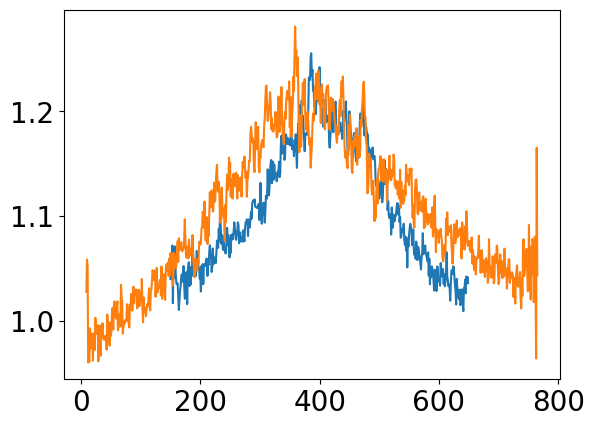

In [11]:
plt.figure()
plt.plot(np.arange(len( np.nanmean(rimg, axis=0)[150:-150])) + 150, np.nanmean(rimg, axis=0)[150:-150])
plt.plot(range(len( np.nanmean(rimg, axis=1))), np.nanmean(rimg, axis=1))
plt.show()

# loop

In [17]:
files = sorted(glob('../data/*_reduced.h5'))
files

['../data\\200.0K_reduced.h5',
 '../data\\225.0K_reduced.h5',
 '../data\\230.0K_reduced.h5',
 '../data\\230.5K_reduced.h5',
 '../data\\231.0K_reduced.h5',
 '../data\\232.0K_reduced.h5']

In [ ]:
# https://lmfit.github.io/lmfit-py/examples/example_two_dimensional_peak.html
def lorentzian2d(x, y, amplitude=1., centerx=0., centery=0., sigmax=1., sigmay=1.,
                 rotation=0, offset = 0):
    """Return a two dimensional lorentzian.

    The maximum of the peak occurs at ``centerx`` and ``centery``
    with widths ``sigmax`` and ``sigmay`` in the x and y directions
    respectively. The peak can be rotated by choosing the value of ``rotation``
    in radians.
    """
    xp = (x - centerx)*np.cos(rotation) - (y - centery)*np.sin(rotation)
    yp = (x - centerx)*np.sin(rotation) + (y - centery)*np.cos(rotation)
    R = (xp/sigmax)**2 + (yp/sigmay)**2

    return 2*amplitude*lorentzian(R)/(np.pi*sigmax*sigmay) + offset


  0%|          | 0/6 [00:00<?, ?it/s]

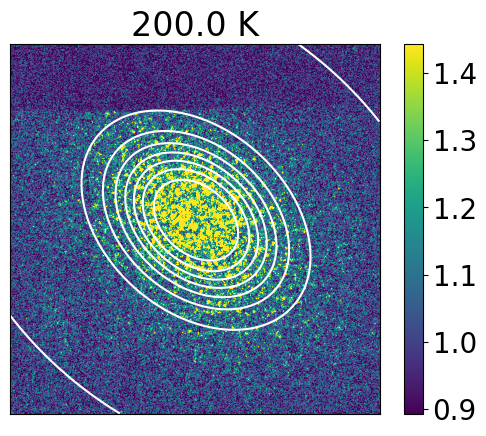

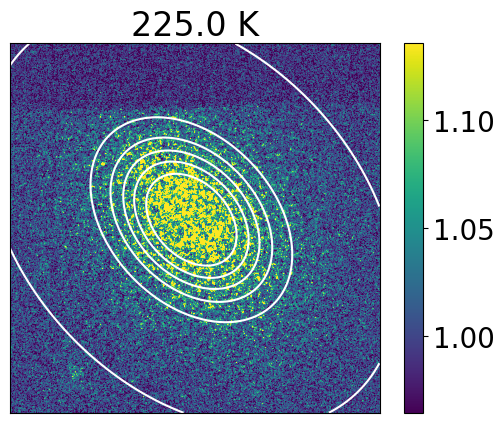

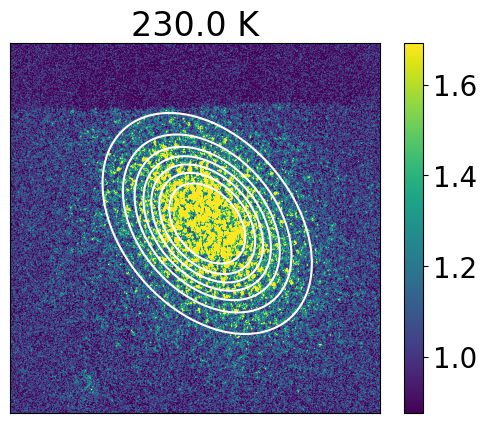

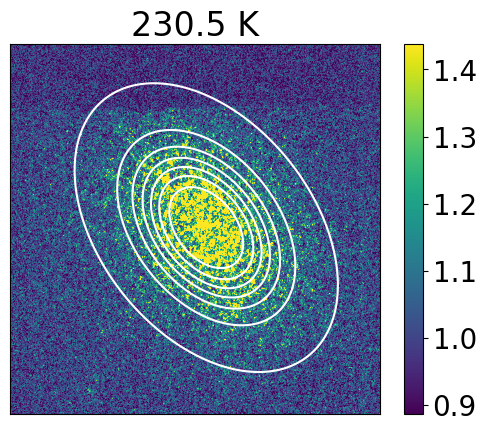

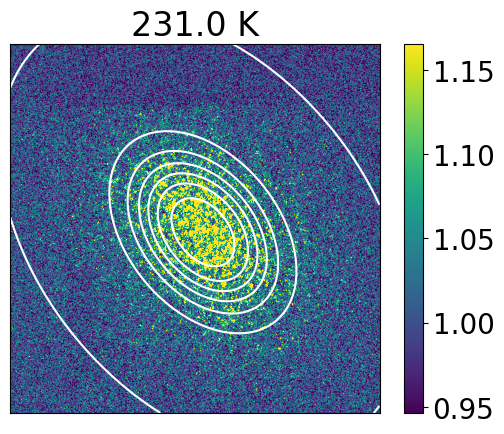

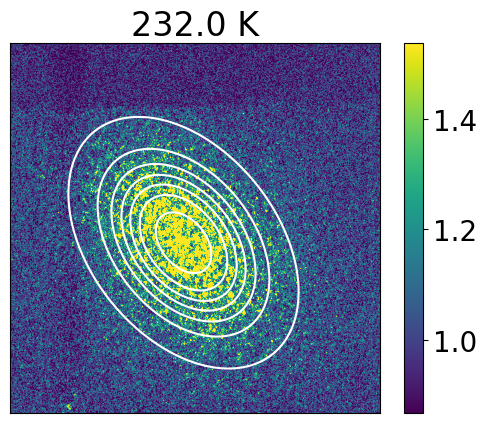

In [47]:
out = []
for f in tqdm(files):
    ds = xr.open_dataset(f)
    img = ds['image_stack'][1].compute().to_numpy()
    gimg = gaussian_filter(img, 35)
    

    x, y = np.indices(gimg.shape)
    mod = Model(lorentzian2d, independent_vars=['x', 'y'])
    params = mod.make_params(amplitude=1)
    params['rotation'].set(value=1, min=0, max=np.pi/2)
    params['sigmax'].set(value=50, min=0, max=500)
    params['sigmay'].set(value=100, min=0, max=500)
    params['centery'].set(value=384, min=200, max=500)
    params['centerx'].set(value=374, min=200, max=500)
    params['offset'].set(value=1)

    error = 1 / np.sqrt(gimg).ravel()
    result = mod.fit(img.ravel(), x=x.ravel(), y=y.ravel(), params=params, weights=1/error)

    fit = mod.func(x, y, **result.best_values)

    plt.figure()
    plt.title(f'{ds.attrs["temperature"]} K')
    plt.imshow(img, vmin=np.percentile(img, 20), vmax=np.percentile(img, 95))
    plt.colorbar()
    plt.contour(fit, colors=['w'])
    plt.xticks([])
    plt.yticks([])
    plt.show()

    iter_dict = result.params.valuesdict()
    iter_dict['rotation_error'] = result.params['rotation'].stderr
    iter_dict['amplitude_error'] = result.params['amplitude'].stderr
    iter_dict['sigmax_error'] = result.params['sigmax'].stderr
    iter_dict['sigmay_error'] = result.params['sigmay'].stderr
    iter_dict['centerx_error'] = result.params['centerx'].stderr
    iter_dict['centery_error'] = result.params['centery'].stderr
    iter_dict['offset_error'] = result.params['offset'].stderr
    iter_dict['temperature'] = ds.attrs["temperature"]

    out.append(iter_dict)
df = pd.DataFrame(out)

In [50]:
df

amplitude     centerx     centery      sigmax      sigmay  rotation  \
0  42305.837330  380.562601  402.111353  123.764773  175.552388  0.720804   
1  12606.583578  381.172119  392.105306  121.980243  174.089144  0.808648   
2  73334.617400  389.264902  426.312434  113.815996  166.918133  0.859980   
3  37719.142923  397.002686  424.288905  107.574184  165.755124  0.899658   
4  11526.589380  407.796113  417.034198  109.478854  165.260103  0.884737   
5  51486.370029  430.935888  375.073565  111.922287  170.785876  0.897564   

     offset  rotation_error  amplitude_error  sigmax_error  sigmay_error  \
0  0.997466        0.005899       173.652090      0.380301      0.544886   
1  0.998488        0.006110        55.230304      0.413399      0.599643   
2  1.003006        0.003958       208.791494      0.240615      0.360879   
3  1.000489        0.004826       152.717837      0.333905      0.558657   
4  0.998877        0.007059        65.353027      0.506187      0.757604   
5  0.993219        0.004401       189.691836      0.325097      0.487984   

   centerx_error  centery_error  offset_error  temperature  
0       0.331981       0.347108      0.000352        200.0  
1       0.361588       0.356198      0.000108        225.0  
2       0.239413       0.229100      0.000481        230.0  
3       0.335169       0.303891      0.000339        230.5  
4       0.468931       0.433237      0.000138        231.0  
5       0.307164       0.279929      0.000411        232.0

In [51]:
df.to_pickle('../data/peak_fits_df.pkl')

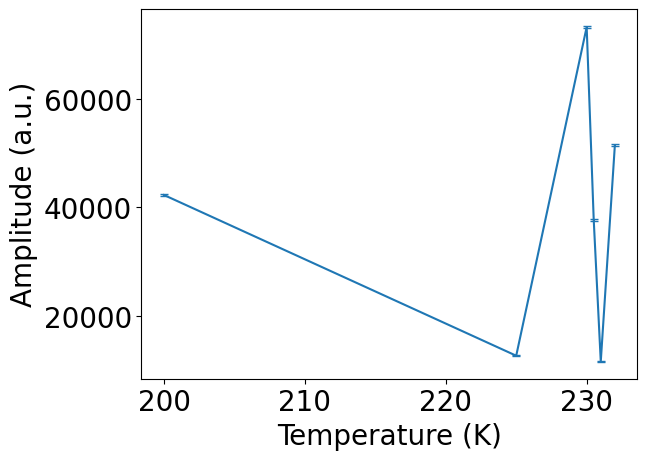

In [55]:
plt.figure()
plt.errorbar(df['temperature'], df['amplitude'], df['amplitude_error'], capsize=3)
plt.xlabel('Temperature (K)')
plt.ylabel('Amplitude (a.u.)')
plt.show()

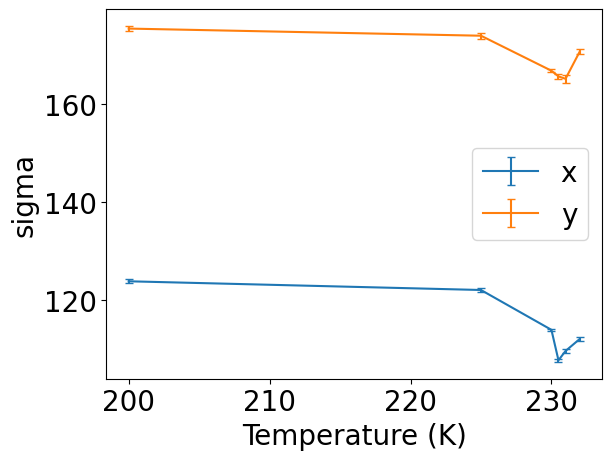

In [59]:
plt.figure()
plt.errorbar(df['temperature'], df['sigmax'], df['sigmax_error'], capsize=3, label='x')
plt.errorbar(df['temperature'], df['sigmay'], df['sigmay_error'], capsize=3, label='y')
plt.legend()
plt.xlabel('Temperature (K)')
plt.ylabel('sigma')
plt.show()